# MNIST handwritten digits classification with MLPs, by hand

Author: Bethany Lusch, adapting notebooks by Prasanna Balaprakash and Taylor Childers

In this notebook, we'll train a multi-layer perceptron model (multi-layer neural network) to classify MNIST digits. We'll build up the code by hand. In the next notebook, we show how this can be done using existing libraries.

First, the needed imports.

In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt

## MNIST data set

Next we'll load the MNIST handwritten digits data set. First time we may have to download the data, which can take a while.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

x_train = x_train.reshape(x_train.shape[0], numpy.prod(x_train[0,:,:].shape))
x_test = x_test.reshape(x_test.shape[0], numpy.prod(x_test[0,:,:].shape))

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

print()
print('MNIST data loaded: train:',len(x_train),'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)


MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 784)
y_train: (60000,)


The training data (x_train) is a matrix of size (60000, 28*28), i.e. it consists of 60000 images that were each of size 28x28 pixels but are now flattened into vectors. y_train is a 60000-dimensional vector containing the correct classes ("0", "1", ..., "9") for each training sample.

Let's take a closer look. Here are the first 10 training digits:

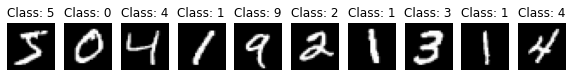

In [3]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(x_train[i,:], (28, 28)), cmap="gray")
    plt.title('Class: '+str(y_train[i]))

## Linear model

Let's begin with a simple linear model: linear regression, like in the previous module. 
We add these extras:
- Each example is a vector (flattened image), so the "slope" multiplication becomes a dot product.
- We consider multiple examples at once. input_images is a matrix where each row is an example.

In [4]:
def linear_model(A, input_images):
    # f(x) = xA returns m-length vector, where m is the number of examples
    return numpy.dot(input_images, A)

In [5]:
def evaluate(A, input_images, true_labels):
    label_predictions = linear_model(A, input_images)
    MSE = numpy.mean((true_labels - label_predictions)**2) 
    return MSE

In [6]:
def learn(input_images, true_labels, current_A, learning_rate=0.000001):
    # first we need dL/dA where L = MSE 
    m = input_images.shape[0] # get number of examples to average over
    label_predictions = linear_model(current_A, input_images)
    # calculate gradient: one entry per partial derivative for an entry in vector A
    dL_dA = (2./m) * numpy.dot(input_images.transpose(), label_predictions - true_labels)
    # now we update A
    new_A = current_A - learning_rate * dL_dA  # SGD update step
    return new_A

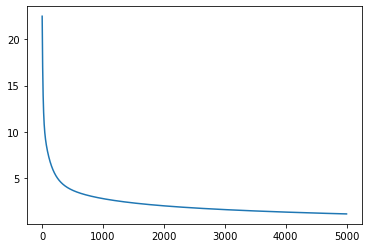

In [7]:
num_features = x_train.shape[1]
A = .01 * numpy.random.rand(num_features,1)
learning_rate = 0.0005  
batch_size = 100

x_train_batch = x_train[:batch_size, :]
y_train_batch = y_train[:batch_size,numpy.newaxis]

num_iters = 5000
losses = numpy.zeros(num_iters,)

for i in range(0, num_iters):
    # all the magic here
    A = learn(x_train_batch, y_train_batch, A, learning_rate)
    losses[i] = evaluate(A, x_train_batch, y_train_batch)
plt.plot(losses)

### Check results so far

As expected, this simple linear model f(x) = xA is not very accurate

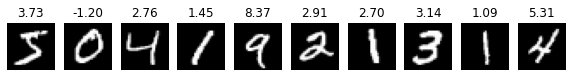

In [8]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
predicted_labels = linear_model(A, x_train[:10,:])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(x_train[i,:], (28, 28)), cmap="gray")
    plt.title('%1.2f' % predicted_labels[i])

### Improving the model

Examples of basic ways to improve:
- Add bias term: f(x) = xA + b
- Reformulate as classification (output integers, not real numbers), like logistic regression

In [9]:
def sigmoid(x):
    z = 1/(1 + numpy.exp(-x))
    return(z)

def classification_model(A, b, input_images):
    # f(x) = sigmoid(xA + b) returns m-length vector, where m is the number of examples
    return sigmoid(numpy.dot(input_images, A) + b)

The sigmoid function encourages outputs of 0 and 1

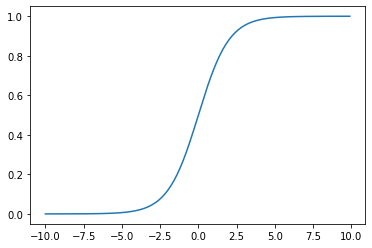

In [10]:
x = numpy.arange(-10, 10, step=.1)
plt.plot(x, sigmoid(x))

To handle 10 classes, it's common to use a one-hot encoding:

In [11]:
# one-hot encoding:
nb_classes = 10
y_train_onehot = tf.keras.utils.to_categorical(y_train, nb_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, nb_classes)

Training sample 0 : class: 5 , one-hot encoded: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Training sample 1 : class: 0 , one-hot encoded: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 2 : class: 4 , one-hot encoded: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Training sample 3 : class: 1 , one-hot encoded: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 4 : class: 9 , one-hot encoded: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Training sample 5 : class: 2 , one-hot encoded: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Training sample 6 : class: 1 , one-hot encoded: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 7 : class: 3 , one-hot encoded: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Training sample 8 : class: 1 , one-hot encoded: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 9 : class: 4 , one-hot encoded: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


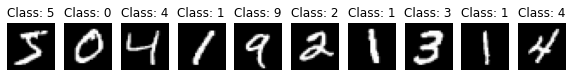

In [12]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(x_train[i,:], (28, 28)), cmap="gray")
    plt.title('Class: '+str(y_train[i]))
    print('Training sample',i,': class:',y_train[i], ', one-hot encoded:', y_train_onehot[i])

## Nonlinear Model

The above improvements are not enough to classify these images. We move to a nonlinear model. 

A neural network has multiple layers. A basic layer is $\sigma(xA + b)$. An example neural network with two layers adds another affine transformation:

$f(x) = \sigma(\sigma(xA_1 + b_1)A_2 + b_2)$

This is often drawn as a network like this:

![simple network](images/tiny_network.png)

Writing it in numpy:

In [13]:
def nonlinear_model(A1, A2, b1, b2, input_images):
    return sigmoid(numpy.dot(sigmoid(numpy.dot(input_images, A1) + b1), A2) + b2)

Adding another layer:

$f(x) = \sigma(\sigma(\sigma(xA_1 + b_1)A_2 + b_2)A_3 + b_3)$

![three-layer network](images/three_layer_network.png)

In [14]:
def nonlinear_model(A1, A2, A3, b1, b2, b3, input_images):
    return sigmoid(numpy.dot(sigmoid(numpy.dot(sigmoid(numpy.dot(input_images, A1) + b1), A2) + b2), A3) + b3)

The nonlinearity doesn't have to be sigmoid. Here are some alteratives:

![activation functions](images/activation_functions.png)

Image source: [Shruti Jadon](https://medium.com/@shrutijadon10104776/survey-on-activation-functions-for-deep-learning-9689331ba092)

The term "deep learning" refers to it being advantageous to have many layers (a "deep" network).

Why is deep learning successful?
- The hierarchical structure saves on parameters (over, say, polynomial regression)
- The universal approximation theorem says that neural networks can approximate "any" smooth function arbitrarily well. 
- Calculating gradients requires the chain rule, but the backpropagation algorithm does this without repeating calculations excessively.

Rather than implement these more complicated networks by hand, we will move to using existing Python packages in the next notebook. To continue by hand, check out [this blog post](https://towardsdatascience.com/coding-a-2-layer-neural-network-from-scratch-in-python-4dd022d19fd2).